<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week4/MHEALTH_1DCNN_LSTM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import glob
import os
import warnings

In [2]:
warnings.filterwarnings('ignore')

# --- 1. 데이터 로드 및 병합 ---
print("--- 1. 데이터 로드 및 병합 시작 ---")
# Google Drive에 마운트된 데이터셋의 경로를 지정합니다.
path = '/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET'

if not os.path.isdir(path):
    print(f"⚠️ 오류: 디렉토리를 찾을 수 없습니다: {path}")
else:
    # 경로에서 mHealth_subject*.log 패턴을 가진 모든 파일을 찾습니다.
    all_files = sorted(glob.glob(os.path.join(path, "mHealth_subject*.log")))
    if not all_files:
        print(f"⚠️ 오류: '{path}' 디렉토리에서 'mHealth_subject*.log' 파일을 찾을 수 없습니다.")
    else:
        print(f"총 {len(all_files)}개의 사용자 파일을 찾았습니다.")
        li = []
        column_names = [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_lead1', 'ecg_lead2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'label'
        ]
        feature_cols = column_names[:-1]

        for filename in all_files:
            df_temp = pd.read_csv(filename, header=None, sep=r'\s+')
            df_temp.columns = column_names
            subject_id = int(''.join(filter(str.isdigit, os.path.basename(filename))))
            df_temp['subject'] = subject_id
            li.append(df_temp)

        df = pd.concat(li, axis=0, ignore_index=True)
        # Null class (label 0)는 활동이 아니므로 제거
        df = df[df['label'] != 0].reset_index(drop=True)

        print("✅ 데이터 로드 및 Null class 제거 완료")
        print(f"전체 데이터 모양: {df.shape}")
        print("데이터 예시:")
        display(df.head())

--- 1. 데이터 로드 및 병합 시작 ---
총 10개의 사용자 파일을 찾았습니다.
✅ 데이터 로드 및 Null class 제거 완료
전체 데이터 모양: (343195, 25)
데이터 예시:


,acc_chest_x,acc_chest_y,acc_chest_z,ecg_lead1,ecg_lead2,acc_ankle_x,acc_ankle_y,acc_ankle_z,gyro_ankle_x,gyro_ankle_y,...,acc_arm_y,acc_arm_z,gyro_arm_x,gyro_arm_y,gyro_arm_z,mag_arm_x,mag_arm_y,mag_arm_z,label,subject
0,-9.7788,0.55690,1.19750,0.008373,-0.033490,2.6493,-9.4517,0.37683,-0.20965,-0.88931,...,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,1
1,-9.7733,0.27880,0.73036,-0.025118,-0.025118,2.4157,-9.5306,0.40179,-0.20965,-0.88931,...,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,1,1
2,-9.8609,0.11561,0.79988,0.025118,0.016745,2.3865,-9.5991,0.48141,-0.20037,-0.86867,...,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,1
3,-9.7409,0.17652,0.88957,0.180010,0.129770,2.3758,-9.5997,0.42919,-0.20037,-0.86867,...,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,1,1
4,-9.7821,0.21637,0.90368,0.092098,0.046049,2.3239,-9.5406,0.40038,-0.20037,-0.86867,...,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,1,1


In [4]:
# --- 2. 슬라이딩 윈도우 생성 (WISDM에서 사용했던 메모리 최적화 버전) ---
print("\n--- 2. 슬라이딩 윈도우 생성 시작 ---")
def create_segments(df, time_steps, step, feature_cols):
    feature_values = df[feature_cols].values
    label_values = df['label'].values
    user_values = df['subject'].values

    num_segments = (len(df) - time_steps) // step + 1

    segments = np.empty((num_segments, time_steps, len(feature_cols)))
    labels = np.empty(num_segments, dtype=int)
    users = np.empty(num_segments, dtype=int)

    idx = 0
    for i in range(0, len(df) - time_steps + 1, step):
        segments[idx] = feature_values[i: i + time_steps]

        label_result = stats.mode(label_values[i: i + time_steps]).mode
        labels[idx] = np.array(label_result).flatten()[0]

        users[idx] = user_values[i]

        idx += 1

    return segments, labels, users

# 논문 및 데이터 특성을 고려한 파라미터 설정
Fs = 50
TIME_STEPS = int(Fs * 2.56)  # 128 (2.56초)
STEP_SIZE = int(TIME_STEPS * 0.5) # 64 (50% 겹침)


--- 2. 슬라이딩 윈도우 생성 시작 ---


In [5]:
X, y, groups = create_segments(df, TIME_STEPS, STEP_SIZE, feature_cols)
# 레이블을 0부터 시작하도록 조정 (원래 1~12 -> 0~11)
y = y - 1
NUM_CLASSES = len(np.unique(y))

# 레이블 인코더는 Classification Report에서 이름 매핑을 위해 생성
le = LabelEncoder()
le.fit(df['label'].map({
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}))

print(f"✅ 생성된 세그먼트 형태: X={X.shape}, y={y.shape}, groups={groups.shape}")
print(f"클래스 개수: {NUM_CLASSES}")

✅ 생성된 세그먼트 형태: X=(5361, 128, 23), y=(5361,), groups=(5361,)
클래스 개수: 12


In [6]:
# --- 3. CNN-LSTM 모델 정의 ---
class HAR_CNN_LSTM(nn.Module):
    def __init__(self, num_classes, num_features):
        super(HAR_CNN_LSTM, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# --- 4. Subject-wise 교차 검증 ---
print("\n--- 4. Subject-wise 교차 검증 시작 ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 요구사항에 따라 10명을 2명씩 5개 그룹으로 나눔 (파일이 9개면 4개는 2명, 1개는 1명)
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

fold_results = []
fold_accuracies = []
all_preds = []
all_labels = []


--- 4. Subject-wise 교차 검증 시작 ---
Using device: cuda


In [8]:
for fold, (train_val_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n========== Fold {fold+1}/{N_SPLITS} ==========")

    model = HAR_CNN_LSTM(NUM_CLASSES, X.shape[2]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # 데이터 스케일링 (훈련 데이터 기준으로)
    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val.reshape(-1, X_train_val.shape[2])).reshape(X_train_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

    # CNN 입력 형태에 맞게 차원 변경: (N, 길이, 채널) -> (N, 채널, 길이)
    X_train = X_train.transpose(0, 2, 1)
    X_val = X_val.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    # Tensor 및 DataLoader 생성
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 모델 훈련
    NUM_EPOCHS = 20 # 에포크 수 조정 가능
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for segments, labels in train_loader:
            segments, labels = segments.to(device), labels.to(device)
            outputs = model(segments)
            loss = criterion(outputs, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)

        model.eval()
        running_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for segments, labels in val_loader:
                segments, labels = segments.to(device), labels.to(device)
                outputs = model(segments)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    fold_results.append(history)

    # 모델 평가
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for segments, labels in test_loader:
            segments, labels = segments.to(device), labels.to(device)
            outputs = model(segments)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    fold_accuracies.append(accuracy)
    print(f'✅ Fold {fold+1} Test Accuracy: {accuracy:.2f} %')


========== Fold 1/5 ==========
Epoch [1/20], Train Loss: 1.4262, Train Acc: 52.39%, Val Loss: 0.5518, Val Acc: 81.90%
Epoch [2/20], Train Loss: 0.3510, Train Acc: 89.56%, Val Loss: 0.2381, Val Acc: 93.50%
Epoch [3/20], Train Loss: 0.2102, Train Acc: 94.16%, Val Loss: 0.1421, Val Acc: 96.98%
Epoch [4/20], Train Loss: 0.0933, Train Acc: 97.47%, Val Loss: 0.0761, Val Acc: 98.38%
Epoch [5/20], Train Loss: 0.0451, Train Acc: 98.99%, Val Loss: 0.0234, Val Acc: 99.77%
Epoch [6/20], Train Loss: 0.0676, Train Acc: 97.68%, Val Loss: 0.0537, Val Acc: 98.38%
Epoch [7/20], Train Loss: 0.0727, Train Acc: 98.40%, Val Loss: 0.2231, Val Acc: 93.04%
Epoch [8/20], Train Loss: 0.0812, Train Acc: 97.91%, Val Loss: 0.0282, Val Acc: 99.30%
Epoch [9/20], Train Loss: 0.0247, Train Acc: 99.51%, Val Loss: 0.0253, Val Acc: 99.54%
Epoch [10/20], Train Loss: 0.0365, Train Acc: 99.15%, Val Loss: 0.0199, Val Acc: 99.54%
Epoch [11/20], Train Loss: 0.0149, Train Acc: 99.72%, Val Loss: 0.0401, Val Acc: 98.84%
Epoch [12


--- 5. 훈련 과정 시각화 ---


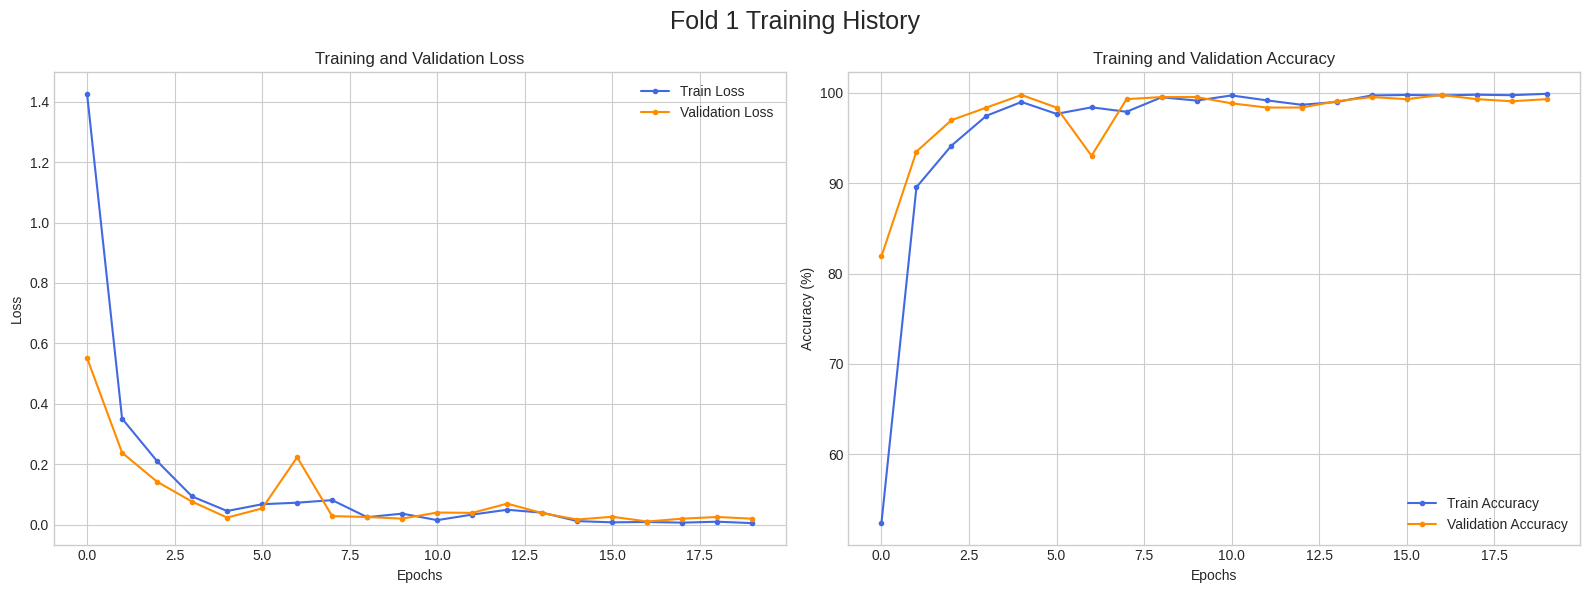

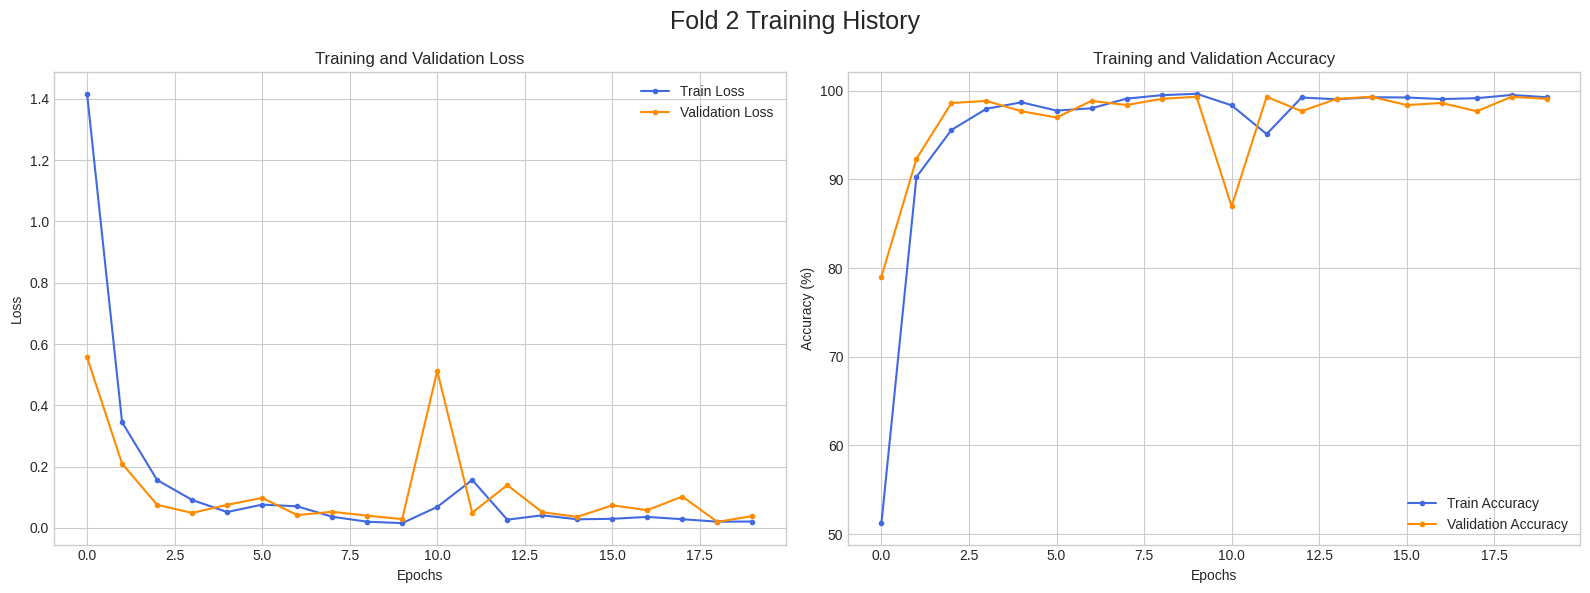

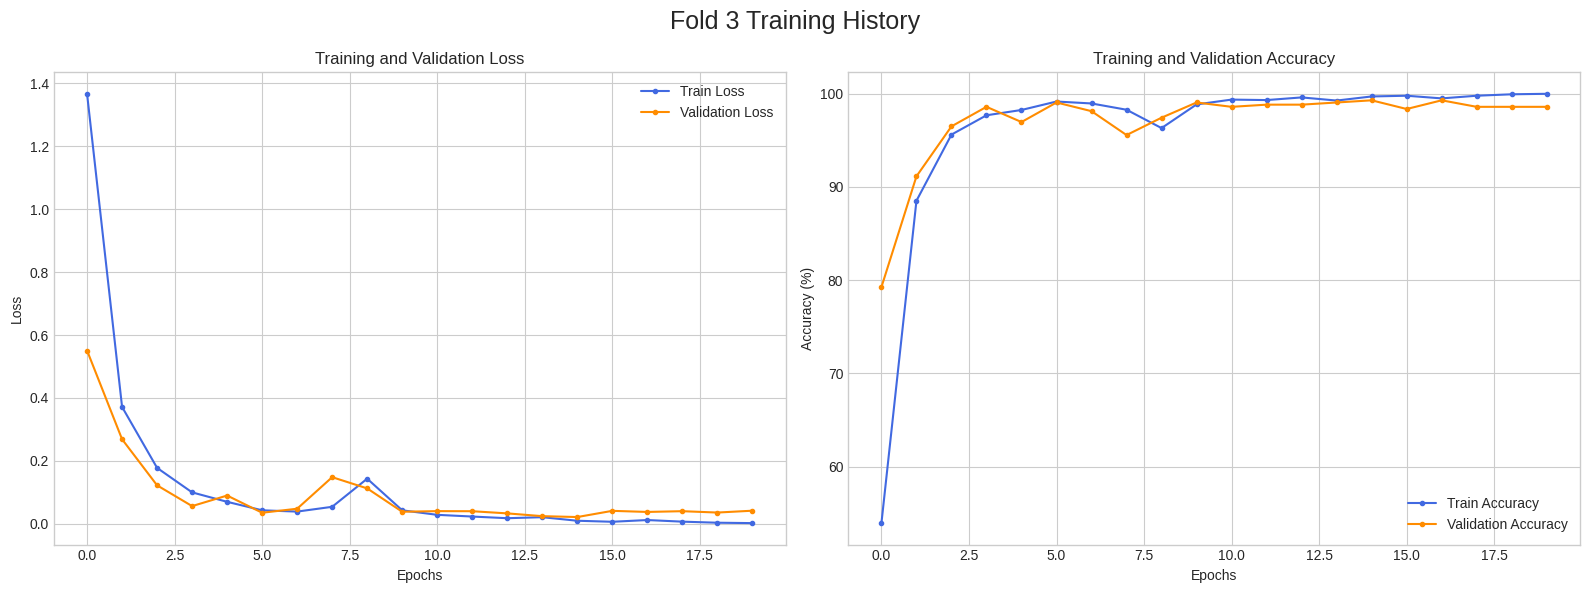

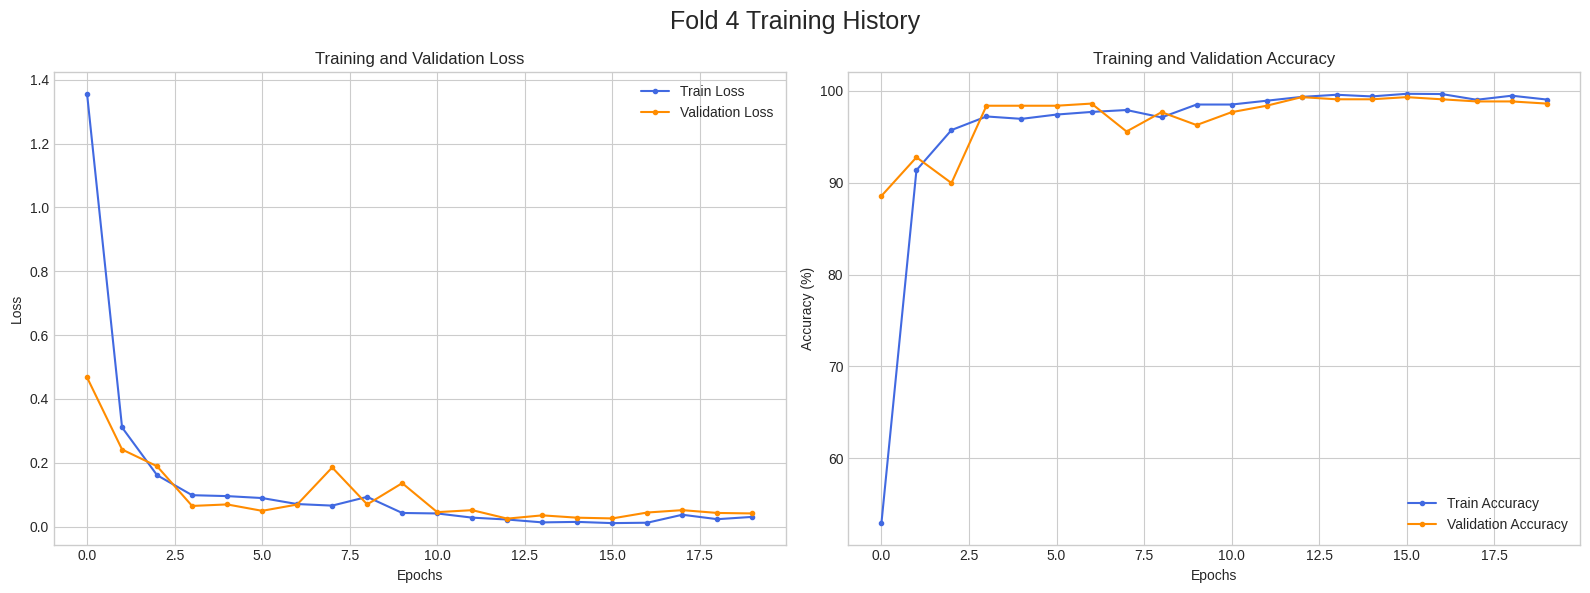

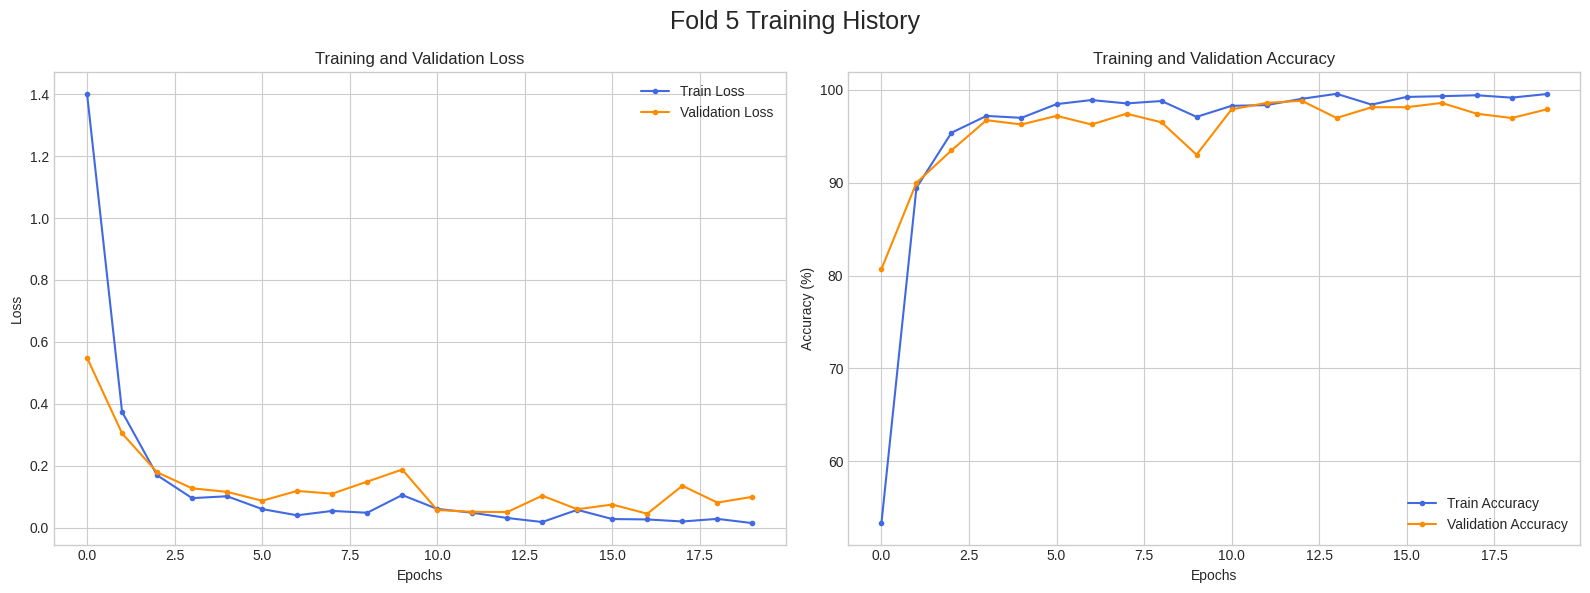

In [9]:
# --- 5. 훈련 과정 시각화 ---
print("\n--- 5. 훈련 과정 시각화 ---")
for i, history in enumerate(fold_results):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Fold {i+1} Training History', fontsize=18)

    ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=3)
    ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=3)
    ax1.set_title('Training and Validation Loss'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy', color='royalblue', marker='o', markersize=3)
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='darkorange', marker='o', markersize=3)
    ax2.set_title('Training and Validation Accuracy'); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)'); ax2.legend()

    plt.tight_layout(); plt.show()

In [11]:
# --- 6. Final Results ---
print("\n\n--- 6. Final Cross-Validation Results ---")
accuracies_np = np.array(fold_accuracies)
print(f"Accuracy per Fold: {accuracies_np}")
print(f"Average Accuracy: {accuracies_np.mean():.2f} %"); print(f"Standard Deviation of Accuracy: {accuracies_np.std():.2f}")



--- 6. Final Cross-Validation Results ---
Accuracy per Fold: [81.96411709 89.14656772 88.81640261 89.26919519 89.81308411]
Average Accuracy: 87.80 %
Standard Deviation of Accuracy: 2.94



--- 7. Classification Report & Confusion Matrix ---
                           precision    recall  f1-score   support

          Climbing stairs       0.97      0.99      0.98       483
                  Cycling       0.97      0.40      0.56       480
Frontal elevation of arms       0.85      1.00      0.92       480
                  Jogging       0.98      0.95      0.97       480
        Jump front & back       0.89      0.95      0.92       479
Knees bending (crouching)       0.89      0.94      0.91       442
               Lying down       0.80      0.99      0.88       460
                  Running       0.85      0.92      0.89       458
     Sitting and relaxing       1.00      0.99      0.99       480
           Standing still       0.76      0.76      0.76       480
      Waist bends forward       0.76      0.77      0.77       480
                  Walking       0.95      0.89      0.92       159

                 accuracy                           0.88      5361
       

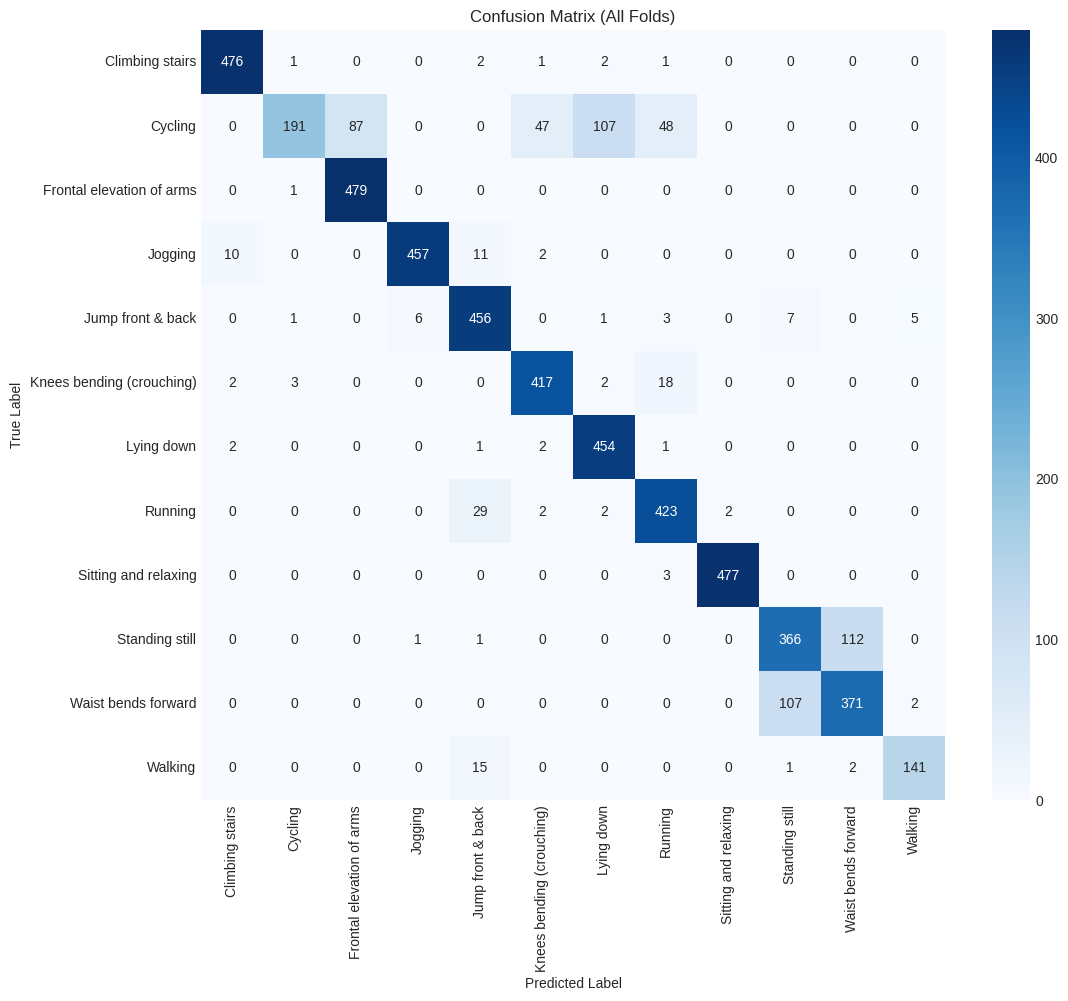

In [12]:
# --- 7. Classification Report & Confusion Matrix ---
print("\n--- 7. Classification Report & Confusion Matrix ---")
# Correctly get the class names based on the actual unique labels in y (0-11)
target_names_actual = [le.classes_[i] for i in sorted(np.unique(y))]

print(classification_report(all_labels, all_preds, target_names=target_names_actual))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_actual, yticklabels=target_names_actual)
plt.title('Confusion Matrix (All Folds)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()